In [34]:
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [35]:
# --- 1. Feature Extraction Functions ---

def extract_global_features(image_bgr):
    """Extracts a 3D color histogram in the HSV color space."""
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_local_features(image_bgr):
    """Extracts Histogram of Oriented Gradients (HOG) features."""
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    return features

In [36]:
# --- 2. Load Data and Extract All Features ---

# Use a subset of CIFAR-10 for faster execution
NUM_SAMPLES = 60000
print(f"Loading a subset of {NUM_SAMPLES} images from CIFAR-10...")
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
images = train_dataset.data[:NUM_SAMPLES]
labels = np.array(train_dataset.targets[:NUM_SAMPLES])
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Extracting global, local, and combined features...")
X_global, X_local, X_combined = [], [], []
for i in tqdm(range(len(images)), desc="Processing Images"):
    # Convert RGB (from PyTorch) to BGR (for OpenCV)
    image_bgr = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
    global_feat = extract_global_features(image_bgr)
    local_feat = extract_local_features(image_bgr)
    X_global.append(global_feat)
    X_local.append(local_feat)
    X_combined.append(np.hstack([global_feat, local_feat]))

X_global, X_local, X_combined = np.array(X_global), np.array(X_local), np.array(X_combined)
y = labels


Loading a subset of 60000 images from CIFAR-10...
Extracting global, local, and combined features...


Processing Images: 100%|██████████| 50000/50000 [00:17<00:00, 2922.04it/s]


In [37]:
# --- 3. Train Models and Get Results ---

def train_and_get_results(X, y, images_subset):
    """Trains an SVM model and returns test data, predictions, and metrics."""
    X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
        X, y, images_subset, test_size=0.25, random_state=42, stratify=y)

    model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    return images_test,X_test, y_test, y_pred, metrics,model

print("\n Training all three models...")
images_test_g, X_test_g, y_test_g, y_pred_g, metrics_g, model_g = train_and_get_results(X_global, y, images)
images_test_l, X_test_l, y_test_l, y_pred_l, metrics_l, model_l = train_and_get_results(X_local, y, images)
images_test_c, X_test_c, y_test_c, y_pred_c, metrics_c, model_c = train_and_get_results(X_combined, y, images)
print("Training and evaluation complete.")



 Training all three models...
Training and evaluation complete.



The Feature Extraction Process...


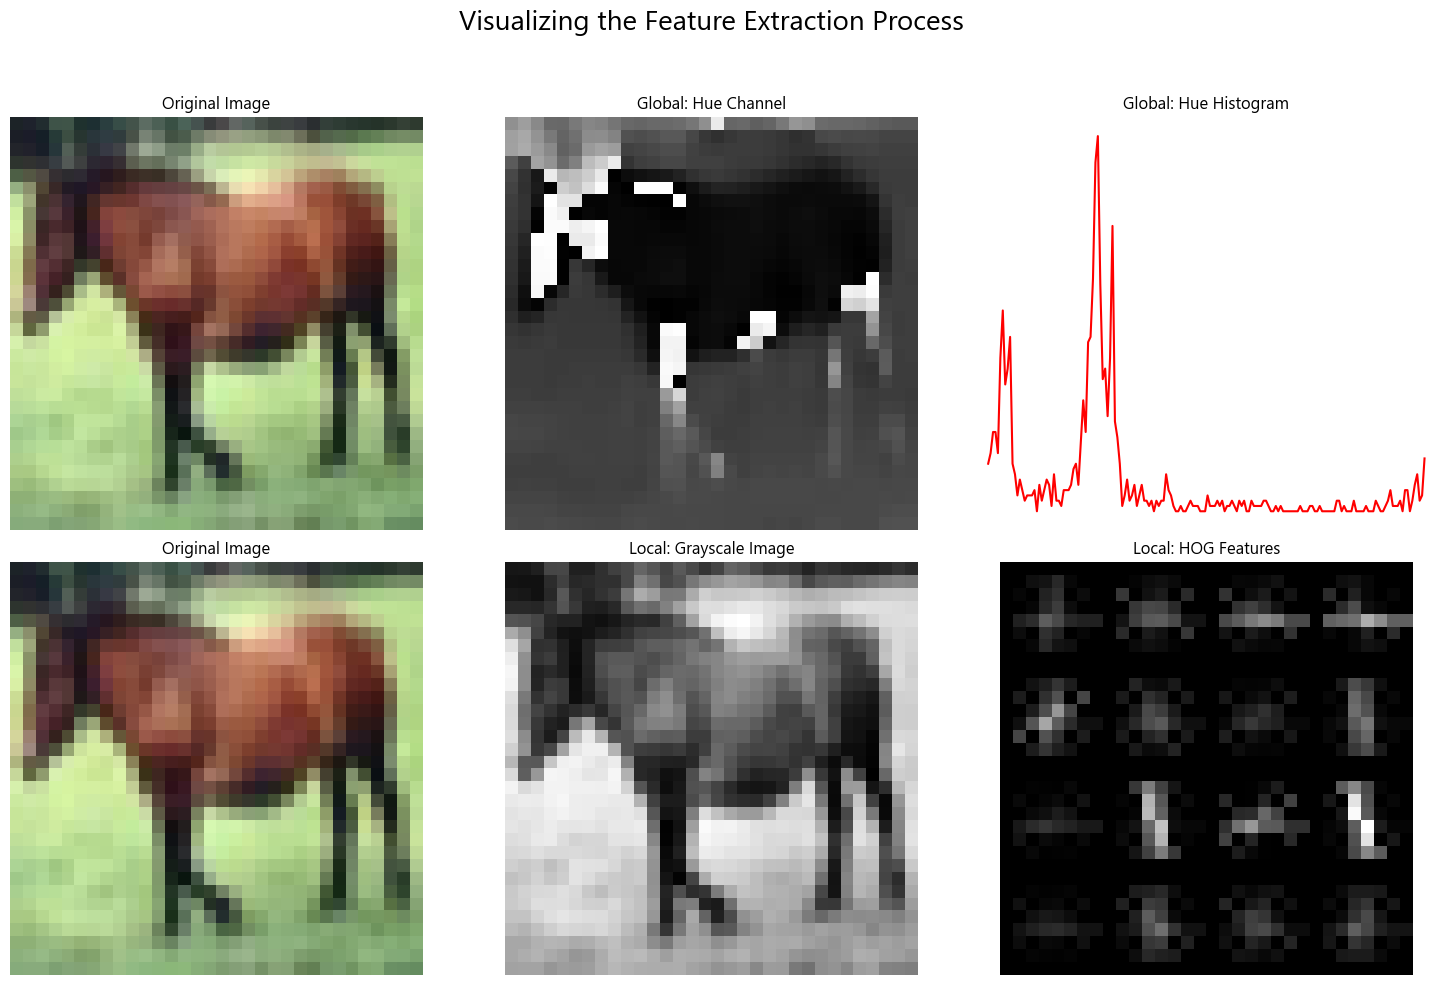

In [38]:
# Visualizations ---

#UNDERSTANDING THE FEATURES
print("\nThe Feature Extraction Process...")
sample_image = images[7] # A horse image
sample_image_bgr = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)
sample_image_gray = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
fd, hog_image = hog(sample_image_gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)
hsv_image = cv2.cvtColor(sample_image_bgr, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Visualizing the Feature Extraction Process', fontsize=20)
axs[0, 0].imshow(sample_image)
axs[0, 0].set_title('Original Image')
# Global Feature Visualization
axs[0, 1].imshow(h, cmap='gray')
axs[0, 1].set_title('Global: Hue Channel')
axs[0, 2].plot(cv2.calcHist([hsv_image], [0], None, [180], [0, 180]), color='r')
axs[0, 2].set_title('Global: Hue Histogram')
# Local Feature Visualization
axs[1, 0].imshow(sample_image)
axs[1, 0].set_title('Original Image')
axs[1, 1].imshow(sample_image_gray, cmap='gray')
axs[1, 1].set_title('Local: Grayscale Image')
axs[1, 2].imshow(hog_image, cmap='gray')
axs[1, 2].set_title('Local: HOG Features')
for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Generating Visualization 2: Overall Performance Metrics...


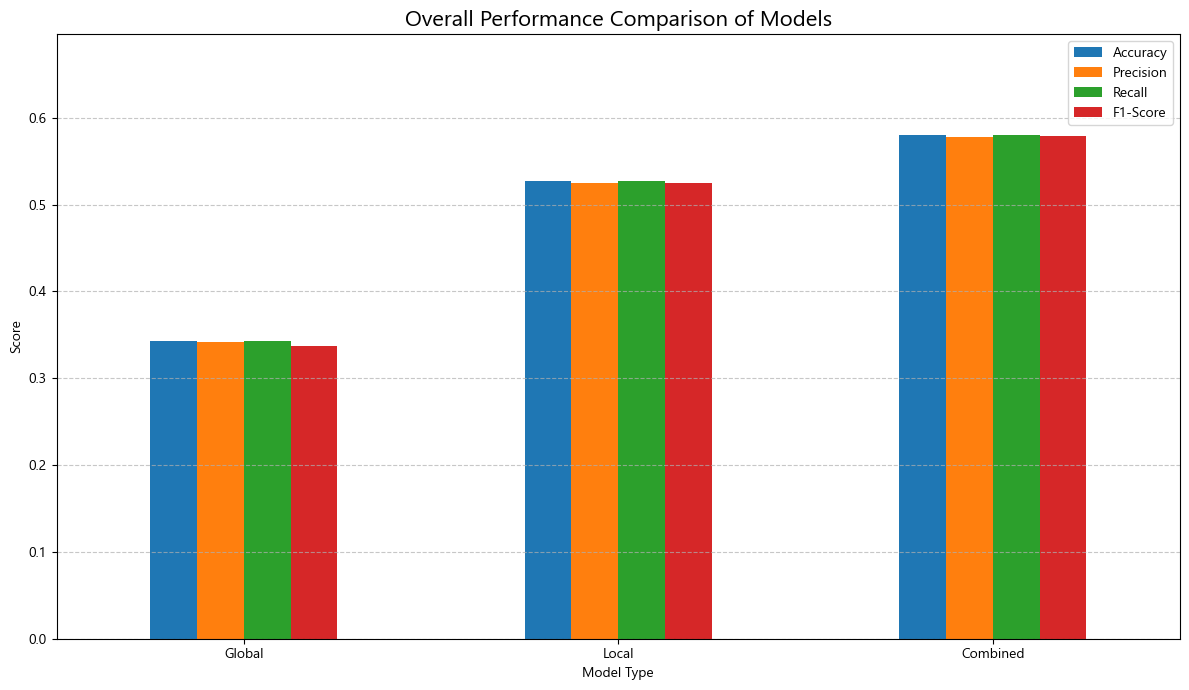

In [39]:
#OVERALL PERFORMANCE COMPARISON
print("Generating Visualization 2: Overall Performance Metrics...")
model_names = ['Global', 'Local', 'Combined']
all_metrics = [metrics_g, metrics_l, metrics_c]
metric_names = list(metrics_g.keys())
plot_data = {name: [m[name] for m in all_metrics] for name in metric_names}
df = pd.DataFrame(plot_data, index=model_names)

df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Overall Performance Comparison of Models', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Model Type')
plt.ylim(0, max(max(df.values.flatten()) * 1.2, 0.6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [40]:
#REPORT FOR EACH MODEL
print("\n💡 Generating Detailed Classification Reports for Each Model...")
from sklearn.metrics import classification_report

# This list is needed to show the names instead of just numbers 0-9
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Detailed Reports for Each Model\n")

# --- Report for the Global Model ---
print("="*25 + " Global Model Report " + "="*25)
# Note: zero_division=0 prevents a warning if a class has no predictions
print(classification_report(y_test_g, y_pred_g, target_names=class_names, zero_division=0))

# --- Report for the Local Model ---
print("\n" + "="*25 + " Local Model Report " + "="*25)
print(classification_report(y_test_l, y_pred_l, target_names=class_names, zero_division=0))

# --- Report for the Combined Model ---
print("\n" + "="*25 + " Combined Model Report " + "="*25)
print(classification_report(y_test_c, y_pred_c, target_names=class_names, zero_division=0))


💡 Generating Detailed Classification Reports for Each Model...
Detailed Reports for Each Model

========================= Global Model Report =========================
              precision    recall  f1-score   support

       plane       0.38      0.50      0.43      1250
         car       0.39      0.38      0.39      1250
        bird       0.30      0.19      0.23      1250
         cat       0.26      0.28      0.27      1250
        deer       0.32      0.32      0.32      1250
         dog       0.24      0.23      0.23      1250
        frog       0.33      0.44      0.38      1250
       horse       0.39      0.21      0.27      1250
        ship       0.41      0.47      0.44      1250
       truck       0.41      0.42      0.41      1250

    accuracy                           0.34     12500
   macro avg       0.34      0.34      0.34     12500
weighted avg       0.34      0.34      0.34     12500


========================= Local Model Report =========================


In [41]:


# Consolidate the metrics from the three models into a dictionary
comparison_data = {
    'Global Model': metrics_g,
    'Local Model': metrics_l,
    'Combined Model': metrics_c
}

# Create a Pandas DataFrame from the dictionary
# The 'orient="index"' argument makes the model names the rows
metrics_df = pd.DataFrame.from_dict(comparison_data, orient='index')

# Format the floating point numbers to 4 decimal places for better readability
formatted_df = metrics_df.style.format("{:.4f}")

print("Performance Metrics Comparison (Numerical Values)\n" + "="*55)

# In a Jupyter Notebook, this will display a nicely formatted HTML table
formatted_df

Performance Metrics Comparison (Numerical Values)


,Accuracy,Precision,Recall,F1-Score
Global Model,0.3434,0.3423,0.3434,0.3371
Local Model,0.5274,0.5245,0.5274,0.5251
Combined Model,0.5802,0.5783,0.5802,0.5790


📊 Generating advanced curve-based metric comparisons...


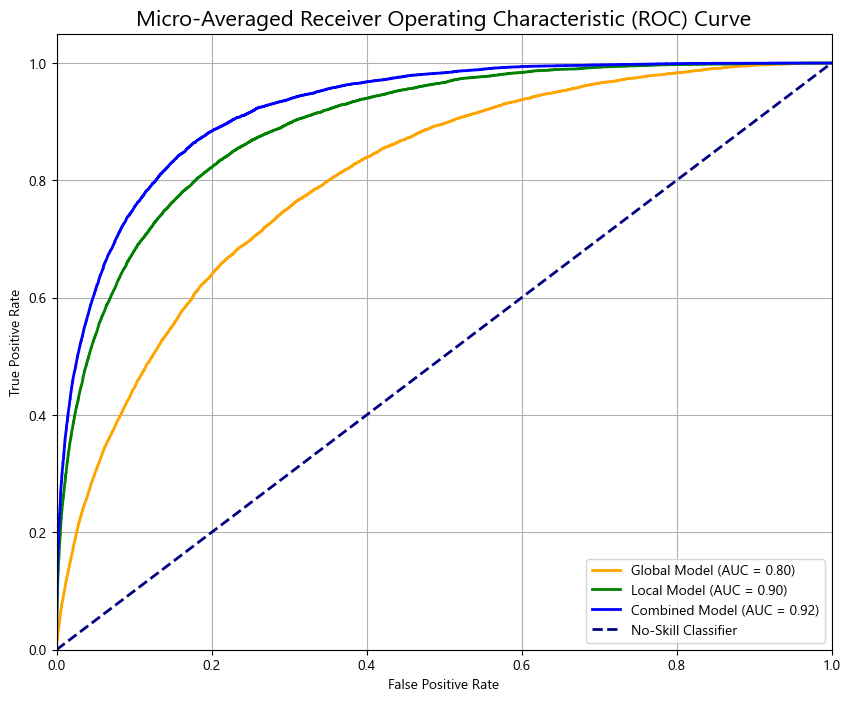

In [42]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

print("📊 Generating advanced curve-based metric comparisons...")

# --- Data Preparation ---
# We need to binarize the labels (one-hot encode) for multi-class ROC/PR analysis
y_test_binarized = label_binarize(y_test_c, classes=range(10))
n_classes = y_test_binarized.shape[1]

# Get the probability scores from each model
# Note: This requires the SVC models to have been trained with `probability=True`
prob_g = model_g.predict_proba(X_test_g)
prob_l = model_l.predict_proba(X_test_l)
prob_c = model_c.predict_proba(X_test_c)

# --- 1. ROC Curve Comparison (Micro-Average) ---

# Calculate micro-averaged ROC curve and ROC area for each model
fpr_g, tpr_g, _ = roc_curve(y_test_binarized.ravel(), prob_g.ravel())
roc_auc_g = auc(fpr_g, tpr_g)

fpr_l, tpr_l, _ = roc_curve(y_test_binarized.ravel(), prob_l.ravel())
roc_auc_l = auc(fpr_l, tpr_l)

fpr_c, tpr_c, _ = roc_curve(y_test_binarized.ravel(), prob_c.ravel())
roc_auc_c = auc(fpr_c, tpr_c)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_g, tpr_g, color='orange', lw=2, label=f'Global Model (AUC = {roc_auc_g:.2f})')
plt.plot(fpr_l, tpr_l, color='green', lw=2, label=f'Local Model (AUC = {roc_auc_l:.2f})')
plt.plot(fpr_c, tpr_c, color='blue', lw=2, label=f'Combined Model (AUC = {roc_auc_c:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No-Skill Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


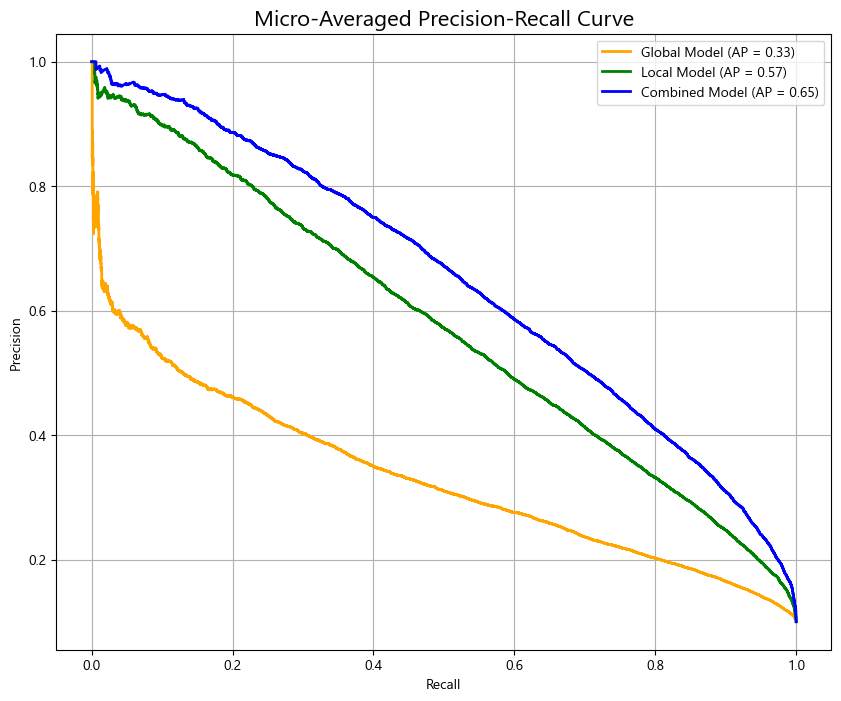

In [43]:
# --- 2. Precision-Recall Curve Comparison (Micro-Average) ---

# Calculate micro-averaged Precision-Recall curve and AP for each model
precision_g, recall_g, _ = precision_recall_curve(y_test_binarized.ravel(), prob_g.ravel())
ap_g = average_precision_score(y_test_binarized, prob_g, average="micro")

precision_l, recall_l, _ = precision_recall_curve(y_test_binarized.ravel(), prob_l.ravel())
ap_l = average_precision_score(y_test_binarized, prob_l, average="micro")

precision_c, recall_c, _ = precision_recall_curve(y_test_binarized.ravel(), prob_c.ravel())
ap_c = average_precision_score(y_test_binarized, prob_c, average="micro")

# Plot the Precision-Recall curves
plt.figure(figsize=(10, 8))
plt.plot(recall_g, precision_g, color='orange', lw=2, label=f'Global Model (AP = {ap_g:.2f})')
plt.plot(recall_l, precision_l, color='green', lw=2, label=f'Local Model (AP = {ap_l:.2f})')
plt.plot(recall_c, precision_c, color='blue', lw=2, label=f'Combined Model (AP = {ap_c:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve', fontsize=16)
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

 The Combined Model processing is better than the individual features models 


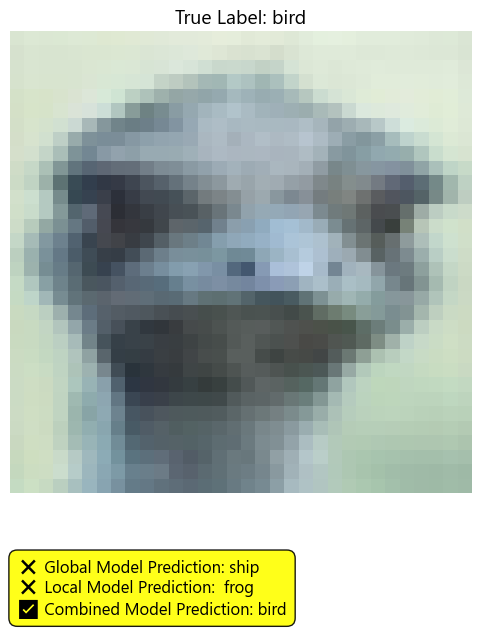

In [44]:
# CASE STUDY IN SUCCESS
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'].insert(0, 'Segoe UI Emoji') # For Windows

print(" The Combined Model processing is better than the individual features models ")
found_example = False
for i in range(len(y_test_c)):
    true_label = y_test_c[i]
    if y_pred_g[i] != true_label and y_pred_l[i] != true_label and y_pred_c[i] == true_label:
        example_image = images_test_c[i]
        true_class = class_names[true_label]
        pred_g_class = class_names[y_pred_g[i]]
        pred_l_class = class_names[y_pred_l[i]]
        pred_c_class = class_names[y_pred_c[i]]
        
        plt.figure(figsize=(8, 6))
        plt.imshow(example_image)
        plt.title(f"True Label: {true_class}", fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.text(0, 36,
                 f"❌ Global Model Prediction: {pred_g_class}\n"
                 f"❌ Local Model Prediction:  {pred_l_class}\n"
                 f"✅ Combined Model Prediction: {pred_c_class}",
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.9),
                 fontsize=12, verticalalignment='top')
        plt.show()
        found_example = True
        break

if not found_example:
    print("Could not find a perfect example in this run. Try increasing NUM_SAMPLES or re-running.")